<a href="https://colab.research.google.com/github/MariaKostopoulou/DatabaseSystems/blob/main/Database_Systems_MKostopoulou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mmh3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.5 MB/s 


In [ ]:
pip install numpy_indexed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the necessary modules
import mmh3
import time
import numpy as np
import numpy_indexed as npi
import pandas as pd
from pandas.api.types import is_numeric_dtype
import string, random
from collections import Counter
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import bootstrap
from scipy.stats import multivariate_normal
from functools import partial
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from math import sqrt

In [ ]:
def generate_n_rand_strings(n_keys, n_chars):
  # Function that creates a set of n defined number of strings constructed by n defined number of characters (letters and digits)
  #we concluded on using only lowercase characters to maximize the probability of larger joins in next steps
  char = np.array(list(string.ascii_lowercase)) #string.ascii_letters ))#+ string.digits))
  keys = set()
  rand_char = partial(np.random.choice, char)
  while len(keys) < n_keys:
        keys |= {''.join([rand_char() for _ in range(n_chars)]) for _ in range(n_keys - len(keys))}
  return keys

def NormalizeData(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))

def generate_bivariate_data(cov_val, n):
  mean = np.array([0,0])
  # Initializing the covariance matrix
  cov = np.array([[1, cov_val], [cov_val, 1]])
  # Generate a Gaussian bivariate distribution with given mean and covariance matrix
  distr = multivariate_normal(cov = cov, mean = mean)
  # Draw n samples out of the distribution
  data = distr.rvs(size = n)
  return data

def generate_mixture_bivariate_data(cov_val, var_val,  n):
  #Generate data from the mixture of 2 multivariate distributions

  # Set mean of the distribution to (0,0)
  mean = np.array([0,0])
  # Initialize the 2 covariance matrices
  cov1 = np.array([[var_val[0], cov_val], [cov_val, var_val[0]]])
  cov2 = np.array([[var_val[1], cov_val], [cov_val, var_val[1]]])

  # Generate a Gaussian bivariate distribution with given mean and covariance matrix
  # Create an array of the generators
  generators = [
                multivariate_normal(mean, cov1),
                multivariate_normal(mean, cov2)]
  # Generate the mixture of Gaussian bivariate distributions by creating the equally weighted random list of indices
  distr = np.random.choice([0, 1], n, p=[0.5,0.5])

  # Generate n samples out of the distribution
  data = np.array([generators[i].rvs() for i in distr])

  return data


def join_tables(x_keys, x_values, y_keys, y_values):
#perform inner join of tables given key values and x, y numerical values
    x_df = pd.DataFrame({"keys": x_keys, "values": x_values.astype(float)})
    y_df = pd.DataFrame({"keys": y_keys, "values": y_values.astype(float)})
    x_y_df = pd.merge( x_df, y_df, on="keys", suffixes=('_x', '_y'))

    return x_y_df

# Fibonacci hashing / golden ratio multiplicative hashing
def Fibonacci_hashing(k):
  p = 14
  m = 2 ** p # hash table's total slots
  w = 32
  s = 2654435769 #A = s/(2 ** w)
  return (k*s % ( 2 ** w))>>(w - p)

# universal-2 Hashing function that maps string values to numbers
#Written by Daniel J. Bernstein (also known as djb)
def hash_djb2(s):
    hash = 5381
    for x in s:
        hash = (( hash << 5) + hash) + ord(x)
    return hash & 0xFFFFFFFF

#Given formula from paper for Fisher z
def Fisher_z(n):
  return (1/np.sqrt(max(4,n)-3))

def Jaccard_calculation(intersection_size, size_set_A, size_set_B):
  #Jaccard similarity  = intersection size / union size
  return (intersection_size)/((size_set_A + size_set_B)-intersection_size)

def pearson_b(sample1, sample2):
  # used for bootstrap calculation
    return pearsonr(sample1, sample2)[0]

In [ ]:
# Tree-based algorithm
def construct_sketch(t, n):
  # create a copy array
  t = np.array([row[:] for row in t])
  # Hash key values into integers
  #h(x) function
  for row in t:
    row[0] = mmh3.hash(row[0])
  t = t.astype(float)

  #second hash function h_u(x), maps integers to range [0,1]
  fib = t[:,0].astype(int)
  for i in range(len(fib)):
    fib[i] = Fibonacci_hashing(fib[i])
  # Normalize the output values of Fibonacci hashing
  fib = NormalizeData(fib)

  # table with structure < h(x), h_u(x), x >
  t = np.insert(t, 1, fib, axis = 1 )

  #Tree-based algorithm as an extension of kmv method
  L_t = np.empty(shape=[n, t.shape[1]])
  k = 0   # counts number of values in new sketch
  for row in t:
    if row[1] not in L_t[:,1]:
      if k < n-1 :
        #adds row in sketch
        L_t[k] = row
        k+=1
      elif row[1] < max(L_t[:,1]):
        #remove row with max val
        L_t = L_t[~(L_t == max(L_t[:,1])).any(axis=1)]
        #add at the end of the array new row
        L_t = np.append(L_t, [row] , axis = 0)

  return L_t

In [ ]:
# selech n min values of h_u(x)
def create_sketch(t, n):
  # create a copy array
  t = np.array([row[:] for row in t])
  # Hash key values into integers
  #h(x) function
  for row in t:
    row[0] = mmh3.hash(row[0])
  t = t.astype(float)

  #second hash function h_u(x), maps integers to range [0,1]
  fib = t[:,0].astype(int)
  for i in range(len(fib)):
    fib[i] = Fibonacci_hashing(fib[i])
  # Normalize the output values of Fibonacci hashing
  fib = NormalizeData(fib)

  # table has form < h(x), h_u(x), x >
  t = np.insert(t, 1, fib, axis = 1 )

  # sort by h_u(x) values : t[:, 1]
  L_t = t[t[:,1].argsort()]

  # keep n min values of h_u(x)
  L_t = L_t[:n]

  return L_t

In [ ]:
def join_corr_sketch_kmv(t_x, t_y, i):
   # create a copy array
    t_x_hashed = np.array([row[:] for row in t_x])
    t_y_hashed = np.array([row[:] for row in t_y])

    #construct data sketches <h(k), h_u(k), x>
    L_t_x = construct_sketch(t_x_hashed, i)
    L_t_y = construct_sketch(t_y_hashed, i)

    #Aggregate using mean function the repeated values of h(x) in sketch
    L_t_x = npi.group_by(L_t_x[:, 0]).mean(L_t_x)[1]
    L_t_y = npi.group_by(L_t_y[:, 0]).mean(L_t_y)[1]

    #Calculate inner join of sketches
    L_t_x_df = pd.DataFrame({"keys": L_t_x[:,0], "values": L_t_x[:,2]})
    L_t_y_df = pd.DataFrame({"keys": L_t_y[:,0], "values": L_t_y[:,2]})
    L_t_x_y_df = pd.merge(L_t_x_df, L_t_y_df, on="keys", suffixes=('_x', '_y'))

    return L_t_x_y_df, L_t_x_df, L_t_y_df

In [ ]:
def join_corr_sketch(t_x, t_y, i):
   # create a copy array
    t_x_hashed = np.array([row[:] for row in t_x])
    t_y_hashed = np.array([row[:] for row in t_y])

    #construct data sketches <h(k), h_u(k), x>
    L_t_x = create_sketch(t_x_hashed, i)
    L_t_y = create_sketch(t_y_hashed, i)

    #Aggregate using mean function the repeated values of h(x) in sketch
    L_t_x = npi.group_by(L_t_x[:, 0]).mean(L_t_x)[1]
    L_t_y = npi.group_by(L_t_y[:, 0]).mean(L_t_y)[1]

    #Calculate inner join of sketches
    L_t_x_df = pd.DataFrame({"keys": L_t_x[:,0], "values": L_t_x[:,2]})
    L_t_y_df = pd.DataFrame({"keys": L_t_y[:,0], "values": L_t_y[:,2]})
    L_t_x_y_df = pd.merge(L_t_x_df, L_t_y_df, on="keys", suffixes=('_x', '_y'))

    return L_t_x_y_df, L_t_x_df, L_t_y_df

In [ ]:
def end_biased_sampling(t,  T):
  #full list of the repeat counts for each value of the join attribute or frequency list
  freq_dic = Counter(t[:,0])
  freq_col = np.zeros(t.shape[0])
  k=0
  for i, j in t:
    freq_col[k] = freq_dic[i]
    k+=1
  #Use universal-2 hash function on join attributes
  hash_col = np.zeros(t.shape[0])
  k=0
  for i, j in t:
    hash_col[k] = hash_djb2(i)
    k+=1
  #Normalize hashed values to unit interval
  hash_col = NormalizeData(hash_col)

  #Add frequency and hashed column to input table
  # table structure < K_x, X, freq_K_x, hashed_K_x >
  t = np.concatenate((t, freq_col.reshape(-1,1),hash_col.reshape(-1,1)), axis=1)

  sample = []

  for i in range(t.shape[0]):
  # add to sample if the frequency of value is above a given threshold T
    if t[i][2].astype(float) > T :
      sample.append(t[i])
    else:
    # calculate probability p_u = frequency of value / threshold T
      p_u = (t[i][2].astype(float) / T)
    # Add to sample if hashed value < p_u
      if t[i][3].astype(float)  < p_u :
        sample.append(t[i])

  return sample


def join_end_biased_sample(t_x, t_y, T):
  # create end-biased samples of given tables
  sample_x = np.array(end_biased_sampling(t_x, T))
  sample_y = np.array(end_biased_sampling(t_y, T))
  # convert to Dataframe format to perfom joining of the tables
  sample_x_df = pd.DataFrame({"keys": sample_x[:,0], "values": sample_x[:,1].astype(float)})
  sample_y_df = pd.DataFrame({"keys": sample_y[:,0], "values": sample_y[:,1].astype(float)})
  sample_x_y_df = pd.merge(sample_x_df, sample_y_df, on="keys", suffixes=('_x', '_y'))

  return sample_x_y_df, sample_x_df, sample_y_df

In [ ]:
def create_random_samples(t, sample_size):
  #used for random sampling, random selection of n samples out of table t
  return np.array([t[i] for i in np.random.randint(0, t.shape[0], sample_size)])

In [ ]:
def actual_estimated_corr_sketches(T_x, T_y, m_sk, min_join):
  #Calculates actual and estimated Pearson correlation
  #additionally save join sizes
  join_sizes = []
  r_x_y      = []
  for t_x, t_y in zip(T_x, T_y):
    #calculate join for Correlation sketches
    L_t_x_y_df, L_x_df, L_y_df = join_corr_sketch(t_x, t_y, m_sk)

    if L_t_x_y_df.shape[0] > min_join :
      corr_L, _ = pearsonr(L_t_x_y_df.values_x, L_t_x_y_df.values_y)
      #apply join on actual tables and calculate correlation estimation
      t_x_y_df = join_tables(t_x[:,0], t_x[:,1].astype(float), t_y[:,0], t_y[:,1].astype(float) )
      corr_a, _ = pearsonr(t_x_y_df.values_x, t_x_y_df.values_y)

      r_x_y.append([corr_a, corr_L])
      join_sizes.append([t_x_y_df.shape[0], L_t_x_y_df.shape[0]])
  return r_x_y, join_sizes

def actual_estimated_corr_sketches_kmv(T_x, T_y, m_sk, min_join):
  #same steps as previously except for correlation sketches contruction based on tree-based algorithm
  join_sizes = []
  r_x_y      = []
  for t_x, t_y in zip(T_x, T_y):
    #calculate join for Correlation sketches
    L_t_x_y_df, L_x_df, L_y_df = join_corr_sketch_kmv(t_x, t_y, m_sk)

    if L_t_x_y_df.shape[0] > min_join :
      corr_L, _ = pearsonr(L_t_x_y_df.values_x, L_t_x_y_df.values_y)

      t_x_y_df = join_tables(t_x[:,0], t_x[:,1].astype(float), t_y[:,0], t_y[:,1].astype(float) )
      corr_a, _ = pearsonr(t_x_y_df.values_x, t_x_y_df.values_y)

      r_x_y.append([corr_a, corr_L])
      join_sizes.append([t_x_y_df.shape[0], L_t_x_y_df.shape[0]])
  return r_x_y, join_sizes


def actual_estimated_eb_sampling(T_x, T_y, sample_size, min_join):
  # calculate actual and estimated Pearson correlation metric using end-biased sampling
  join_sizes = []
  r_x_y      = []
  for t_x, t_y in zip(T_x, T_y):
    #calculate join for end-biased samples
    eb_S_x_y_df, eb_S_x_df, eb_S_y_df = join_end_biased_sample(t_x, t_y, sample_size)

    if eb_S_x_y_df.shape[0] > min_join :
      corr_eb_S = pearsonr(eb_S_x_y_df.values_x, eb_S_x_y_df.values_y)[0]

      t_x_y_df = join_tables(t_x[:,0], t_x[:,1].astype(float), t_y[:,0], t_y[:,1].astype(float) )
      corr_a = pearsonr(t_x_y_df.values_x, t_x_y_df.values_y)[0]

      r_x_y.append([corr_a, corr_eb_S])
      join_sizes.append([ eb_S_x_y_df.shape[0],eb_S_x_df.shape[0], eb_S_y_df.shape[0] ]) # [ join_size of eb_samples, size of eb_sample of t_x, size of eb_sample of t_y ]
  return r_x_y, join_sizes


def actual_estimated_corr_random_samples(T_x, T_y, sample_size, min_join):
  # calculate actual and estimated Pearson correlation metric using random sampling
  r_x_y      = []
  for t_x, t_y in zip(T_x, T_y):
    #calculate join for Correlation sketches
    S_x = create_random_samples(t_x, sample_size)
    S_y = create_random_samples(t_y, sample_size)
    S_x_y_df, S_x_df, S_y_df = join_tables(S_x[:,0], S_x[:,1].astype(float), S_y[:,0], S_y[:,1].astype(float) )

    if S_x_y_df.shape[0] > min_join :
      corr_S, _ = pearsonr(S_x_y_df.values_x, S_x_y_df.values_y)

      t_x_y_df = join_tables(t_x[:,0], t_x[:,1].astype(float), t_y[:,0], t_y[:,1].astype(float) )
      corr_a, _ = pearsonr(t_x_y_df.values_x, t_x_y_df.values_y)

      r_x_y.append([corr_a, corr_S])
  return r_x_y

In [ ]:
def inverted_index_function( query_t_x,  corpus_t, match_condition):

  match_count_dict = dict() #stores the array number as a key, and the number of matches with query_t_x words as a value to that key

  inverted_index_dict = dict() #stores each word of query_t_x as a key and the arrays that matched each word as a value

  deduplicated_words = set() #keeps the deduplicated words of query_t_x
  # iterate through the words and add them to the set
  for word in query_t_x[:,0]:
    deduplicated_words.add(word)

  #for every array of words
  for array_number, t_y_array in enumerate(corpus_t):
    #for every word of each array
    for word in t_y_array[:,0]:
      # check if it exists in the query_t_x set(if it matches with any word) | otherwise, pass
      if(word in deduplicated_words):

        #first store this array_number, and increment its value (the number of matches)
        match_count_dict[array_number] = 1 if array_number not in match_count_dict else match_count_dict[array_number] + 1

        # if it exists, we check if this is the first time this word matched with an array
        if word in inverted_index_dict:
          # if it'snot the first time, then append the number of this array(its index) in word's dictionary values
          inverted_index_dict[word].append(array_number)
        else:
          #if it is the first time, create the key for the first time and add its value ( index )
          inverted_index_dict[word] = [array_number]


  #filter the match_count_dict and store only keys within a specific range of values (match_condition)
  match_count_dict = {k:v for (k,v) in match_count_dict.items() if v > match_condition}

  return inverted_index_dict, match_count_dict


# this will print each word of query_t_x and the arrays it matched with (uncomment if wanted)
# print(inverted_index_results[0])

# this will print the number of matches each array had with query_t_x words matching our filtering conditions
#print(inverted_index_results[1])

In [ ]:
def create_T_tables(n_tables, max_rows):
#create 2 lists of pairs of tables T_x and T_y
# <K_x, X> and <K_y, Y>
# numerical values X and Y drawn from bivariate distribution
  T_x = []
  T_y = []

  for i in range(n_tables):

    if max_rows == True :
    #set a fixed maximum number of rows
      n_rows = 50000
    else:
    # n number of tuples : random number drawn uniformly in the range (0, 50000)
    # To generate random numbers from the Uniform distribution we will use random.uniform() method of random module.
      n_rows = int(np.random.uniform(0, 50000))

    #create an array of random strings consisting of 4 characters
    #this strings are assigned as key values K_x and K_y later
    rand_strs = np.array(list(generate_n_rand_strings(n_rows,4)))

    #covariance value is drawn uniformly at random from (−1, 1)
    cov_val = np.random.uniform(-1, 1)
    data = generate_bivariate_data(cov_val, n_rows)
    #concatenate array with random strings and bivariate data in form < K_x, X, Y >
    t = np.concatenate((rand_strs.reshape(-1,1), data), axis=1)

    # split table t to tables t_x and t_y with structure <K_x, X>, <K_x, Y>
    t_x = t[:, [0,1]]
    t_y = t[:, [0,2]]

    # 𝑛′ = 𝑛 ∗ 𝑐, where 𝑐 is a random real number in the range (0, 1)
    c = np.random.uniform(0.2, 1)
    n_y = int(n_rows*c)

    # reduce the size of the table T𝑌 from 𝑛 to 𝑛′ by selecting a uniform random sample of size 𝑛′ = 𝑛 ∗ 𝑐
    # <K_y, Y>
    t_y = t_y[:n_y]

    T_x.append(t_x)
    T_y.append(t_y)

  return T_x, T_y



def create_T_tables_mixture_multivariate(n_tables, max_rows):
#create 2 lists of pairs of tables T_x and T_y
# <K_x, X> and <K_y, Y>
# numerical values X and Y drawn from mixture of bivariate distribution
  T_x = []
  T_y = []

  for i in range(n_tables):

    if max_rows == True :
      n_rows = 50000
    else:
    # n number of tuples : random number drawn uniformly in the range (0, 500000)
    # To generate random numbers from the Uniform distribution we will use random.uniform() method of random module.
      n_rows = int(np.random.uniform(0, 50000))
    #create an array of random strings consisting of 4 characters
    #this strings are assigned as key values K_x and K_y later
    rand_strs = np.array(list(generate_n_rand_strings(n_rows,4)))

    cov_val = np.random.uniform(-1, 1)
    data = generate_mixture_bivariate_data(cov_val, [1,10], n_rows)
    #concatenate array with random strings and bivariate data in form < K_x, X, Y >
    t = np.concatenate((rand_strs.reshape(-1,1), data), axis=1)

    t_x = t[:, [0,1]]
    t_y = t[:, [0,2]]

    # 𝑛′ = 𝑛 ∗ 𝑐, where 𝑐 is a random real number in the range (0, 1)
    c = np.random.uniform(0.2, 1)
    n_y = int(n_rows*c)

    # reduce the size of the table T𝑌 from 𝑛 to 𝑛′ by selecting a uniform random sample of size 𝑛′ = 𝑛 ∗ 𝑐
    # <K_y, Y>
    t_y = t_y[:n_y]

    T_x.append(t_x)
    T_y.append(t_y)

  return T_x, T_y

# *Implementation*

Firstly, we create 2 lists of size 500 of tables T_x and T_y

In [ ]:
T_x, T_y = create_T_tables(500, False)

In this part we want to compare the 2 proposed methods of composing correlation sketches.


*   Tree-based algorithm
*   N minimum values of h_u(x) hash function outputs



In [ ]:
#create two lists to store execution time for two methods
#L_t_x_kmv = []
#L_t_x_n_sorted = []
time_kmv = []
time_n_sorted = []

for t_x in T_x:
  start_time = time.time()
  #construct data sketches <h(k), h_u(k), x> based on kmv approach
  L_t_x = construct_sketch(t_x, 256)
  #L_t_x_kmv.append(L_t_x)
  time_kmv.append(time.time() - start_time)

  start_time = time.time()
    #construct data sketches <h(k), h_u(k), x> based on n min h_u(k) values
  L_t_x_n = create_sketch(t_x, 256)
  #L_t_x_n_sorted.append( L_t_x_n )
  time_n_sorted.append(time.time() - start_time)

In [ ]:
print('Mean time for tree-based method {:.4f}'.format(np.mean(time_kmv)))
print('Mean time for min h_u values method {:.4f}'.format(np.mean(time_n_sorted)))

Mean time for tree-based method 0.5907
Mean time for min h_u values method 0.0899


Next, we check is one of the 2 proposed methods produces bigger join sizes of correlation sketches or not.

In [ ]:
join_sketch_sizes = []
for t_x, t_y in zip(T_x, T_y):
  #compute join based on min h_u values
  L_t_x_y_df, L_x_df, L_y_df = join_corr_sketch(t_x, t_y, 256)
  # compute join based on tree-based method
  L_t_x_y_kmv_df, L_x__kmv_df, L_y__kmv_df = join_corr_sketch_kmv(t_x, t_y, 256)
  # append to list in form [join_size of min h_u values, join_size of tree-based method]
  join_sketch_sizes.append([L_t_x_y_df.shape[0],L_t_x_y_kmv_df.shape[0] ])

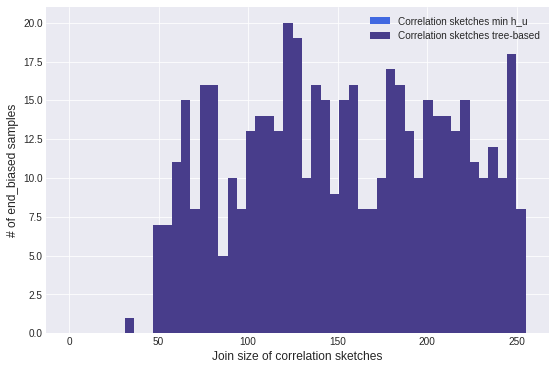

In [ ]:
join_sketch_sizes = np.array(join_sketch_sizes)

plt.style.use('seaborn-darkgrid')
bins = np.linspace(0, max(join_sketch_sizes[:,0]), 50)
plt.figure(figsize=(9,6))
plt.hist(join_sketch_sizes[:,0], bins,  label='Correlation sketches min h_u',color = 'royalblue' )
plt.hist(join_sketch_sizes[:,1], bins,  label='Correlation sketches tree-based',color = 'darkslateblue')
plt.xlabel("Join size of correlation sketches", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.legend(loc='upper right')
plt.show()

We compare the efficiency of tree-based method by comparing actual and estimated correlation estimations. Size of correlation sketches 256 and for join sizes > 3.

In [ ]:
#Correlation sketches for m = 256 and n>=3
r_x_y_kmv, join_sizes_kmv = actual_estimated_corr_sketches_kmv(T_x, T_y, 256, 3)

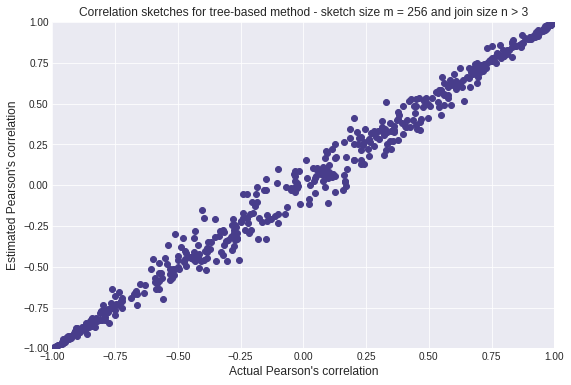

In [ ]:
r_x_y_kmv = np.array(r_x_y_kmv)
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))

plt.scatter(r_x_y_kmv[:,0], r_x_y_kmv[:,1],color = 'darkslateblue')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Actual Pearson's correlation", fontsize=12)
plt.ylabel("Estimated Pearson's correlation", fontsize=12)
plt.title("Correlation sketches for tree-based method - sketch size m = 256 and join size n > 3")
plt.show()

Produce same results for the other method too. Correlation sketches size again fixed at 256 and for correlation sketches sizes >3.
Additionally print join sizes of actual tables t_x and t_y.

In [ ]:
#Correlation sketches for m = 256 and n>=3
r_x_y, join_sizes = actual_estimated_corr_sketches(T_x, T_y, 256, 3)

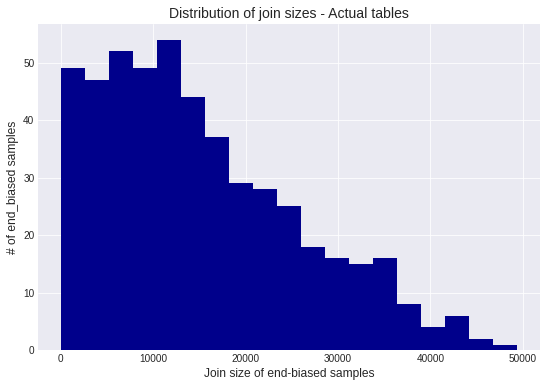

In [ ]:
join_sizes = np.array(join_sizes)
plt.style.use('seaborn-darkgrid')

bins = np.linspace(0, max(join_sizes[:,0]), 20)
plt.figure(figsize=(9,6))
plt.hist(join_sizes[:,0], bins, color = 'darkblue')
plt.xlabel("Join size of end-biased samples", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.title("Distribution of join sizes - Actual tables",fontsize=14)
plt.show()

Actual vs estimated correlation estimations for n minimum h_u(x) values method.

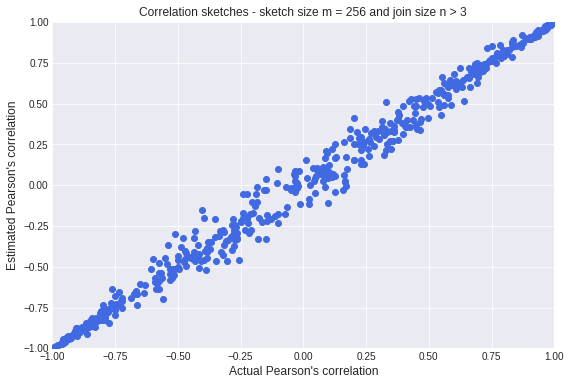

In [ ]:
r_x_y = np.array(r_x_y)
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))

plt.scatter(r_x_y[:,0], r_x_y[:,1],color = 'royalblue')#'mediumslateblue')#'mediumaquamarine')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Actual Pearson's correlation", fontsize=12)
plt.ylabel("Estimated Pearson's correlation", fontsize=12)
plt.title("Correlation sketches - sketch size m = 256 and join size n > 3")
plt.show()

Same as previously but for correlation sketches size > 30.

In [ ]:
#Correlation sketches for m = 256 and n>=3
r_x_y, join_sizes = actual_estimated_corr_sketches(T_x, T_y, 256, 30)

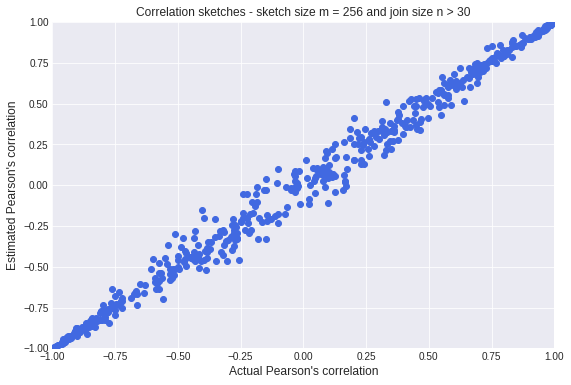

In [ ]:
r_x_y = np.array(r_x_y)
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))

plt.scatter(r_x_y[:,0], r_x_y[:,1],color = 'royalblue')#'mediumslateblue')#'mediumaquamarine')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Actual Pearson's correlation", fontsize=12)
plt.ylabel("Estimated Pearson's correlation", fontsize=12)
plt.title("Correlation sketches - sketch size m = 256 and join size n > 30")
plt.show()

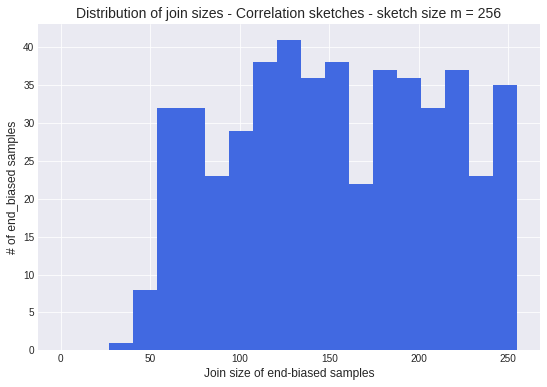

In [ ]:
join_sizes = np.array(join_sizes)
plt.style.use('seaborn-darkgrid')

bins = np.linspace(0, max(join_sizes[:,1]), 20)
plt.figure(figsize=(9,6))
plt.hist(join_sizes[:,1], bins, color = 'royalblue')
plt.xlabel("Join size of end-biased samples", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.title("Distribution of join sizes - Correlation sketches - sketch size m = 256",fontsize=14)
plt.show()

In [ ]:
def actual_estimated_eb_sampling(T_x, T_y, sample_size, min_join):
  join_sizes = []
  r_x_y      = []
  for t_x, t_y in zip(T_x, T_y):
    #calculate join for end-biased samples
    eb_S_x_y_df, eb_S_x_df, eb_S_y_df = join_end_biased_sample(t_x, t_y, sample_size)

    if eb_S_x_y_df.shape[0] > min_join :
      corr_eb_S = pearsonr(eb_S_x_y_df.values_x, eb_S_x_y_df.values_y)[0]

      t_x_y_df = join_tables(t_x[:,0], t_x[:,1].astype(float), t_y[:,0], t_y[:,1].astype(float) )
      corr_a = pearsonr(t_x_y_df.values_x, t_x_y_df.values_y)[0]

      r_x_y.append([corr_a, corr_eb_S])
      join_sizes.append([t_x_y_df.shape[0], eb_S_x_y_df.shape[0]])
  return r_x_y, join_sizes

In [ ]:
r_x_y_eb, join_sizes_eb = actual_estimated_eb_sampling(T_x, T_y, 200, 3)

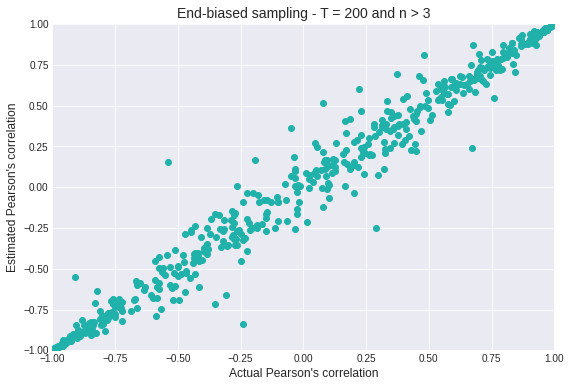

In [ ]:
r_x_y_eb = np.array(r_x_y_eb)
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))

plt.scatter(r_x_y_eb[:,0], r_x_y_eb[:,1],color = 'lightseagreen')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Actual Pearson's correlation", fontsize=12)
plt.ylabel("Estimated Pearson's correlation", fontsize=12)
plt.title("End-biased sampling - T = 200 and n > 3",fontsize=14)
plt.show()

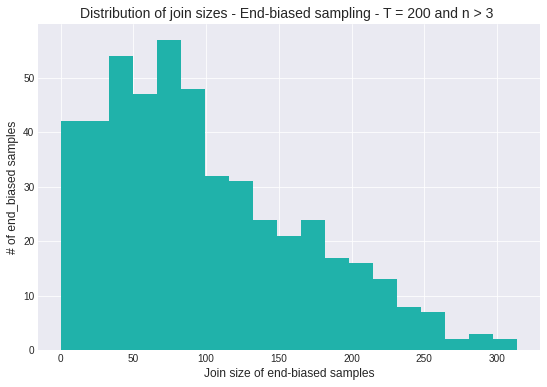

In [ ]:
join_sizes_eb = np.array(join_sizes_eb)
plt.style.use('seaborn-darkgrid')

bins = np.linspace(0, max(join_sizes_eb[:,0]), 20)
plt.figure(figsize=(9,6))
plt.hist(join_sizes_eb[:,0], bins, color = 'lightseagreen')
plt.xlabel("Join size of end-biased samples", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.title("Distribution of join sizes - End-biased sampling - T = 200 and n > 3 ",fontsize=14)
plt.show()

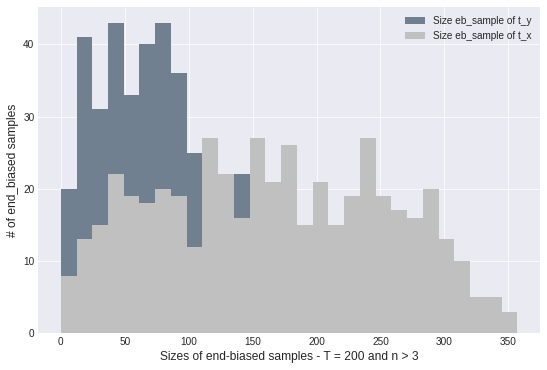

In [ ]:
plt.style.use('seaborn-darkgrid')
bins = np.linspace(0, max(join_sizes_eb[:,1]), 30)
plt.figure(figsize=(9,6))
plt.hist(join_sizes_eb[:,2], bins,  label='Size eb_sample of t_y',color = 'slategray')
plt.hist(join_sizes_eb[:,1], bins,  label='Size eb_sample of t_x',color = 'silver' )

plt.xlabel("Sizes of end-biased samples - T = 200 and n > 3", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.legend(loc='upper right')
plt.show()

In [ ]:
r_x_y_eb2, join_sizes_eb2 = actual_estimated_eb_sampling(T_x, T_y, 100, 3)

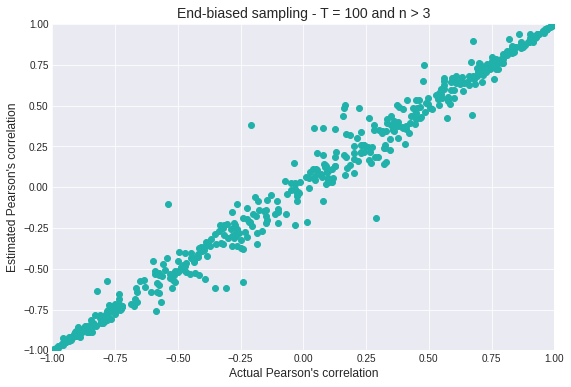

In [ ]:
r_x_y_eb2 = np.array(r_x_y_eb2)
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))

plt.scatter(r_x_y_eb2[:,0], r_x_y_eb2[:,1],color = 'lightseagreen')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Actual Pearson's correlation", fontsize=12)
plt.ylabel("Estimated Pearson's correlation", fontsize=12)
plt.title("End-biased sampling - T = 100 and n > 3",fontsize=14)
plt.show()

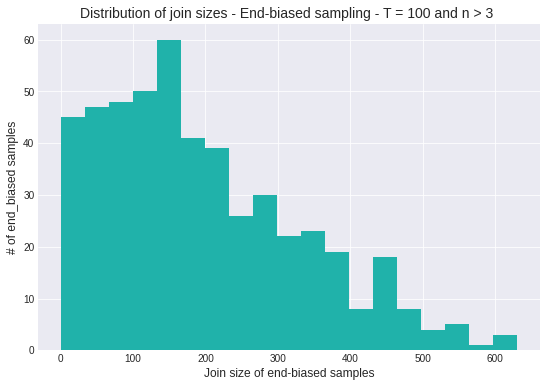

In [ ]:
join_sizes_eb2 = np.array(join_sizes_eb2)
plt.style.use('seaborn-darkgrid')

bins = np.linspace(0, max(join_sizes_eb2[:,0]), 20)
plt.figure(figsize=(9,6))
plt.hist(join_sizes_eb2[:,0], bins, color = 'lightseagreen')
plt.xlabel("Join size of end-biased samples", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.title("Distribution of join sizes - End-biased sampling - T = 100 and n > 3 ",fontsize=14)
plt.show()

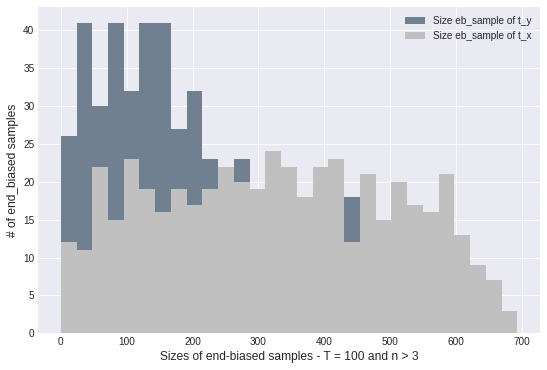

In [ ]:
plt.style.use('seaborn-darkgrid')
bins = np.linspace(0, max(join_sizes_eb2[:,1]), 30)
plt.figure(figsize=(9,6))
plt.hist(join_sizes_eb2[:,2], bins,  label='Size eb_sample of t_y',color = 'slategray')
plt.hist(join_sizes_eb2[:,1], bins,  label='Size eb_sample of t_x',color = 'silver' )

plt.xlabel("Sizes of end-biased samples - T = 100 and n > 3", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.legend(loc='upper right')
plt.show()

In [ ]:
r_x_y_eb3, join_sizes_eb3 = actual_estimated_eb_sampling(T_x, T_y, 300, 3)

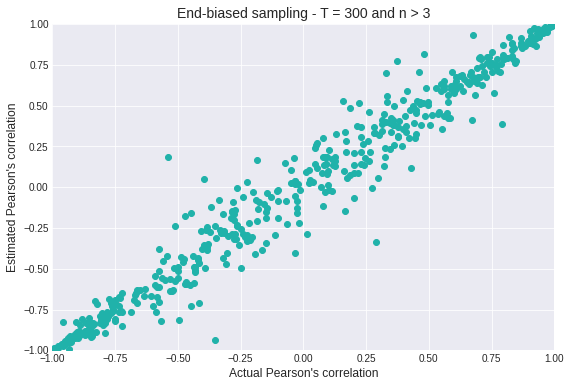

In [ ]:
r_x_y_eb3 = np.array(r_x_y_eb3)
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))

plt.scatter(r_x_y_eb3[:,0], r_x_y_eb3[:,1],color = 'lightseagreen')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Actual Pearson's correlation", fontsize=12)
plt.ylabel("Estimated Pearson's correlation", fontsize=12)
plt.title("End-biased sampling - T = 300 and n > 3",fontsize=14)
plt.show()

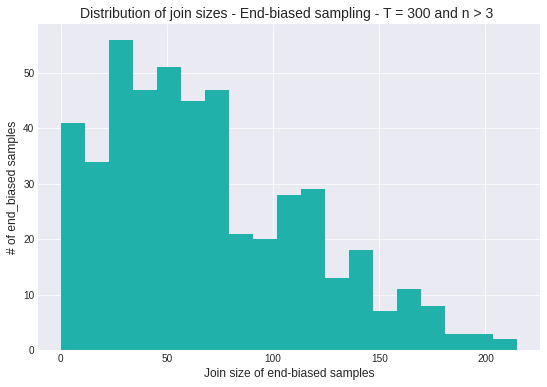

In [ ]:
join_sizes_eb3 = np.array(join_sizes_eb3)
plt.style.use('seaborn-darkgrid')

bins = np.linspace(0, max(join_sizes_eb3[:,0]), 20)
plt.figure(figsize=(9,6))
plt.hist(join_sizes_eb3[:,0], bins, color = 'lightseagreen')
plt.xlabel("Join size of end-biased samples", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.title("Distribution of join sizes - End-biased sampling - T = 300 and n > 3 ",fontsize=14)
plt.show()

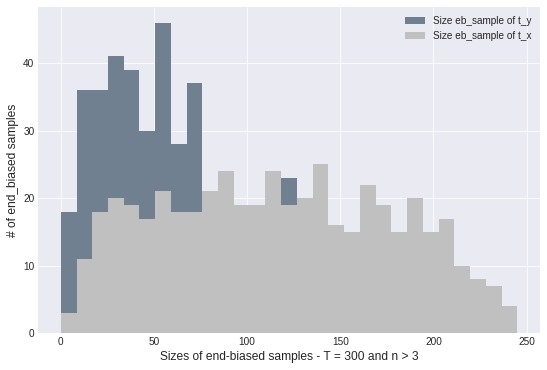

In [ ]:
plt.style.use('seaborn-darkgrid')
bins = np.linspace(0, max(join_sizes_eb3[:,1]), 30)
plt.figure(figsize=(9,6))
plt.hist(join_sizes_eb3[:,2], bins,  label='Size eb_sample of t_y',color = 'slategray')
plt.hist(join_sizes_eb3[:,1], bins,  label='Size eb_sample of t_x',color = 'silver' )

plt.xlabel("Sizes of end-biased samples - T = 300 and n > 3", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.legend(loc='upper right')
plt.show()

In [ ]:
r_x_y_rs = actual_estimated_corr_sketches(T_x, T_y, 300, 3)

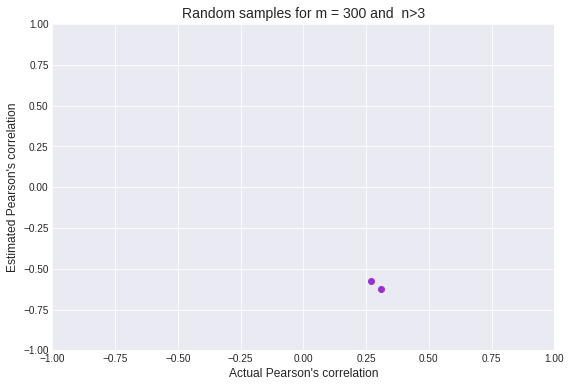

In [ ]:
r_x_y_rs = np.array(r_x_y_rs)
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))

plt.scatter(r_x_y_rs[:,0], r_x_y_rs[:,1],color = 'darkorchid')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Actual Pearson's correlation", fontsize=12)
plt.ylabel("Estimated Pearson's correlation", fontsize=12)
plt.title("Random samples for m = 300 and  n>3",fontsize=14)
plt.show()

In this part we make the same experiments but for synthetic data generated from a mixture of 2 multivariate distributions.

In [ ]:
T_x_m, T_y_m = create_T_tables_mixture_multivariate(300, False)

In [ ]:
#Correlation sketches for m = 256 and n>=3
r_x_y_m, join_sizes_m = actual_estimated_corr_sketches(T_x_m, T_y_m, 256, 3)

We print the join sizes similarly to previous step.

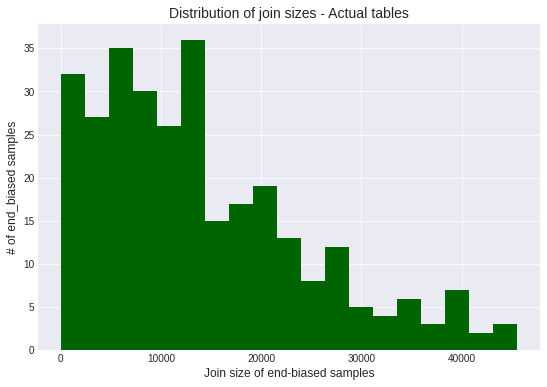

In [ ]:
join_sizes_m = np.array(join_sizes_m)
plt.style.use('seaborn-darkgrid')

bins = np.linspace(0, max(join_sizes_m[:,0]), 20)
plt.figure(figsize=(9,6))
plt.hist(join_sizes_m[:,0], bins, color = 'darkgreen')
plt.xlabel("Join size of end-biased samples", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.title("Distribution of join sizes - Actual tables",fontsize=14)
plt.show()

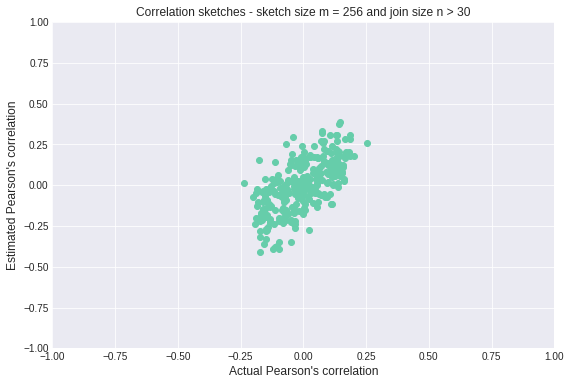

In [ ]:
r_x_y_m = np.array(r_x_y_m)
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))

plt.scatter(r_x_y_m[:,0], r_x_y_m[:,1],color = 'mediumaquamarine')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("Actual Pearson's correlation", fontsize=12)
plt.ylabel("Estimated Pearson's correlation", fontsize=12)
plt.title("Correlation sketches - sketch size m = 256 and join size n > 30")
plt.show()

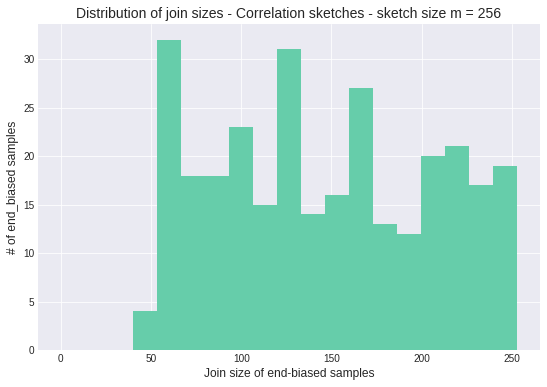

In [ ]:
join_sizes_m = np.array(join_sizes_m)
plt.style.use('seaborn-darkgrid')

bins = np.linspace(0, max(join_sizes_m[:,1]), 20)
plt.figure(figsize=(9,6))
plt.hist(join_sizes_m[:,1], bins, color = 'mediumaquamarine')
plt.xlabel("Join size of end-biased samples", fontsize=12)
plt.ylabel("# of end_biased samples", fontsize=12)
plt.title("Distribution of join sizes - Correlation sketches - sketch size m = 256",fontsize=14)
plt.show()

# **RMSE**

In [ ]:
#small example running bootstrap
t_xi = T_x[0]
t_yi = T_y[0]
t_x_y_i = join_tables(t_xi[:,0], t_xi[:,1], t_yi[:,0] , t_yi[:,1]    )
from scipy.stats import bootstrap
data = (t_x_y_i.values_x, t_x_y_i.values_y)
res = bootstrap(data, pearson_b, vectorized=False, paired=True)
ci_l, ci_u = res.confidence_interval
print(res.confidence_interval)

In [ ]:
print(res.confidence_interval)

ConfidenceInterval(low=-0.30309058094097063, high=-0.2577009008940256)


In [ ]:
def RMSE_Pearson_Spearman(T_x, T_y, max_size_sketches, step):

  rmse_corr = []
  rmse_rho  = []
  #rmse_bootstrap = []


  for i in range(50,max_size_sketches,step):
    corr_l = []
    rho_l  = []
    bootstrap_l = []
    for t_x, t_y in zip(T_x, T_y):
      #perform join in actual tables
      t_x_df = pd.DataFrame({"keys": t_x[:,0], "values": t_x[:,1].astype(float)})
      t_y_df = pd.DataFrame({"keys": t_y[:,0], "values": t_y[:,1].astype(float)})
      t_x_y_df = pd.merge(t_x_df, t_y_df, on="keys", suffixes=('_x', '_y'))

      #calculate Pearson's and Spearman's correlation metric on actual tables
      corr_a, _ = pearsonr(t_x_y_df.values_x, t_x_y_df.values_y)
      rho_a, _ = spearmanr(t_x_y_df.values_x, t_x_y_df.values_y)

      #Calculate confindence intervals using bootstrap method
      #not enough RAM provided by Google Colab
      #res = bootstrap((t_x_y_df.values_x, t_x_y_df.values_y) , pearson_b, vectorized=False, paired=True)
      #ci_l_a, ci_u_a = res.confidence_interval
      #cor_boot_a = corr_a*(1-( ci_u_a - ci_l_a)/2)

      #calculate join for Correlation sketches
      L_t_x_y_df, L_x_df, L_y_df = join_corr_sketch(t_x, t_y, i)

      corr_e, _ = pearsonr(L_t_x_y_df.values_x, L_t_x_y_df.values_y)
      rho_e, _ = spearmanr(L_t_x_y_df.values_x, L_t_x_y_df.values_y)

      #Calculate confindence intervals using bootstrap method based on sketches
      #not enough RAM
      #res_L = bootstrap((L_t_x_y_df.values_x, L_t_x_y_df.values_y) , pearson_b, vectorized=False, paired=True)
      #ci_l_e, ci_u_e = res.confidence_interval
      #cor_boot_e = corr_e*(1-( ci_u_e - ci_l_e)/2)

      #Store actual and estimated Pearson's and Spearman's metrics on list to calculate RMSE
      corr_l.append([corr_a, corr_e])
      rho_l.append([rho_a, rho_e])
      #bootstrap_l.append([cor_boot_a, cor_boot_e])

    corr_l = np.array(corr_l)
    rho_l  = np.array(rho_l)
    #bootstrap_l = np.array(bootstrap_l)

    rmse_corr.append(sqrt(mean_squared_error(corr_l[:,0], corr_l[:,1])))
    rmse_rho.append(sqrt(mean_squared_error(rho_l[:,0], rho_l[:,1])))
    #rmse_bootstrap.append( sqrt(mean_squared_error(bootstrap_l[:,0], bootstrap_l[:,1])))

  return {"rmse_Pearson": rmse_corr, "rmse_Spearman": rmse_rho}

In [ ]:
def create_T_tables_for_RMSE(n_tables, max_rows):
#T_x and T_y tables of same size to get correlation sketches sizes in RMSE_Pearson_Spearman iterator
  T_x = []
  T_y = []

  for i in range(n_tables):

    if max_rows == True :
      n_rows = 50000
    else:
    # n number of tuples : random number drawn uniformly in the range (0, 500000)
    # To generate random numbers from the Uniform distribution we will use random.uniform() method of random module.
      n_rows = int(np.random.uniform(0, 50000))

    rand_strs = np.array(list(generate_n_rand_strings(n_rows,4)))

    cov_val = np.random.uniform(-1, 1)
    data = generate_bivariate_data(cov_val, n_rows)
    t = np.concatenate((rand_strs.reshape(-1,1), data), axis=1)

    t_x = t[:, [0,1]]
    t_y = t[:, [0,2]]

    T_x.append(t_x)
    T_y.append(t_y)

  return T_x, T_y

In [ ]:
T_x, T_y = create_T_tables_for_RMSE(100, False)

In [ ]:
RMSE_256 = RMSE_Pearson_Spearman(T_x, T_y, 256,10)

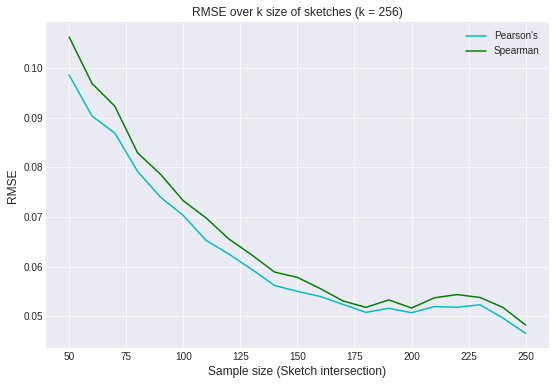

In [ ]:
m_sk = list(range(50,256,10))
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))
plt.plot(m_sk, RMSE_256['rmse_Pearson'],'c', label = "Pearson's")
plt.plot(m_sk, RMSE_256['rmse_Spearman'],'g', label = 'Spearman')
plt.xlabel("Sample size (Sketch intersection)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title('RMSE over k size of sketches (k = 256)')
plt.legend()
plt.show()

In [ ]:
RMSE_500 = RMSE_Pearson_Spearman(T_x, T_y, 500,25)

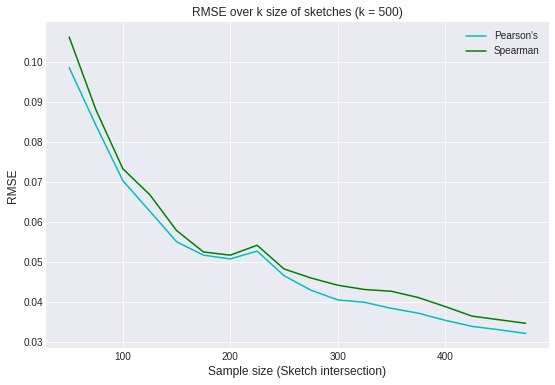

In [ ]:
m_sk = list(range(50,500,25))
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))
plt.plot(m_sk, RMSE_500['rmse_Pearson'],'c', label = "Pearson's")
plt.plot(m_sk, RMSE_500['rmse_Spearman'],'g', label = 'Spearman')
plt.xlabel("Sample size (Sketch intersection)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title('RMSE over k size of sketches (k = 500)')
plt.legend()
plt.show()

In [ ]:
def create_T_tables_mixture_multivariate_RMSE(n_tables, max_rows):
#T_x and T_y tables of same size to get correlation sketches sizes in RMSE_Pearson_Spearman iterator

  T_x = []
  T_y = []

  for i in range(n_tables):

    if max_rows == True :
      n_rows = 50000
    else:
    # n number of tuples : random number drawn uniformly in the range (0, 500000)
    # To generate random numbers from the Uniform distribution we will use random.uniform() method of random module.
      n_rows = int(np.random.uniform(0, 50000))

    rand_strs = np.array(list(generate_n_rand_strings(n_rows,4)))

    cov_val = np.random.uniform(-1, 1)
    data = generate_mixture_bivariate_data(cov_val, [1,10], n_rows)

    t = np.concatenate((rand_strs.reshape(-1,1), data), axis=1)

    t_x = t[:, [0,1]]
    t_y = t[:, [0,2]]

    T_x.append(t_x)
    T_y.append(t_y)

  return T_x, T_y

In [ ]:
T_x_m, T_y_m = create_T_tables_mixture_multivariate_RMSE(100, False)

In [ ]:
RMSE_256_m = RMSE_Pearson_Spearman(T_x_m, T_y_m, 256,10)

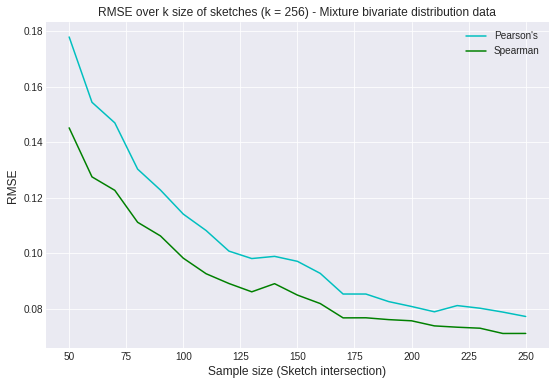

In [ ]:
m_sk = list(range(50,256,10))
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(9,6))
plt.plot(m_sk, RMSE_256_m['rmse_Pearson'],'c', label = "Pearson's")
plt.plot(m_sk, RMSE_256_m['rmse_Spearman'],'g', label = 'Spearman')
plt.xlabel("Sample size (Sketch intersection)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title('RMSE over k size of sketches (k = 256) - Mixture bivariate distribution data')
plt.legend()
plt.show()

Execution time for join, Pearson's and Spearman on actual tables and sketches.

In [ ]:
def execution_time_full_t_sketches(T_x, T_y):

  #create lists to store time records for join, Pearson's and Spearman estimation calculation

  time_join_a = []
  time_join_L = []
  time_p_a = []
  time_p_L = []
  time_s_a = []
  time_s_L = []

  for t_x, t_y in zip(T_x, T_y):
    #record time for join on actual tables
    start_time = time.time()
    t_x_y_df = join_tables(t_x[:,0], t_x[:,1].astype(float), t_y[:,0], t_y[:,1].astype(float) )
    time_join_a.append(time.time() - start_time)

    #record time for Pearson's and Spearman's correlation metric on actual tables
    start_time = time.time()
    corr_a, _ = pearsonr(t_x_y_df.values_x, t_x_y_df.values_y)
    time_p_a.append(time.time() - start_time)

    start_time = time.time()
    rho_a, _ = spearmanr(t_x_y_df.values_x, t_x_y_df.values_y)
    time_s_a.append(time.time() - start_time)


    # create a copy array
    t_x_hashed = np.array([row[:] for row in t_x])
    t_y_hashed = np.array([row[:] for row in t_y])

    #construct data sketches <h(k), h_u(k), x>
    L_t_x = create_sketch(t_x_hashed, 256)
    L_t_y = create_sketch(t_y_hashed, 256)

    #Aggregate using mean function the repeated values of h(x) in sketch
    L_t_x = npi.group_by(L_t_x[:, 0]).mean(L_t_x)[1]
    L_t_y = npi.group_by(L_t_y[:, 0]).mean(L_t_y)[1]

    L_t_x_df = pd.DataFrame({"keys": L_t_x[:,0], "values": L_t_x[:,2]})
    L_t_y_df = pd.DataFrame({"keys": L_t_y[:,0], "values": L_t_y[:,2]})

    start_time = time.time()
    #construct data sketches <h(k), h_u(k), x> based on n min h_u(k) values
    #record time for join on Correlation sketches
    L_t_x_y_df = pd.merge(L_t_x_df, L_t_y_df, on="keys", suffixes=('_x', '_y'))
    time_join_L.append(time.time() - start_time)

    #calculate Pearson's and Spearman's correlation metric on correlation sketches
    start_time = time.time()
    corr_e, _ = pearsonr(L_t_x_y_df.values_x, L_t_x_y_df.values_y)
    time_p_L.append(time.time() - start_time)

    start_time = time.time()
    rho_e, _ = spearmanr(L_t_x_y_df.values_x, L_t_x_y_df.values_y)
    time_s_L.append(time.time() - start_time)

  return {"Join_actual": time_join_a, "Join_sketches": time_join_L, "Join_Pearson_a": time_p_a, "Join_Pearson_L": time_p_L, "Join_Spearman_a": time_s_a, "Join_Spearman_L":time_s_L}

In [ ]:
ex_time = execution_time_full_t_sketches(T_x,T_y)

In [ ]:
for key in ex_time:
  print("===============")
  print(key)
  print("===============")
  print('Mean time (sec) {:.4f}'.format(np.mean(ex_time[key])))
  print('Std time (sec) {:.4f}'.format(np.std(ex_time[key])))
  print("75% Percentile time (sec) {:.4f}".format(np.percentile(ex_time[key],75)))
  print("95% Percentile time (sec) {:.4f}".format(np.percentile(ex_time[key],95)))
  print("99% Percentile time (sec) {:.4f}".format(np.percentile(ex_time[key],99)))

Join_actual
Mean time (sec) 0.0455
Std time (sec) 0.0276
75% Percentile time (sec) 0.0631
95% Percentile time (sec) 0.0889
99% Percentile time (sec) 0.1099
Join_sketches
Mean time (sec) 0.0027
Std time (sec) 0.0007
75% Percentile time (sec) 0.0027
95% Percentile time (sec) 0.0039
99% Percentile time (sec) 0.0046
Join_Pearson_a
Mean time (sec) 0.0007
Std time (sec) 0.0007
75% Percentile time (sec) 0.0008
95% Percentile time (sec) 0.0011
99% Percentile time (sec) 0.0026
Join_Pearson_L
Mean time (sec) 0.0004
Std time (sec) 0.0003
75% Percentile time (sec) 0.0004
95% Percentile time (sec) 0.0006
99% Percentile time (sec) 0.0007
Join_Spearman_a
Mean time (sec) 0.0057
Std time (sec) 0.0041
75% Percentile time (sec) 0.0079
95% Percentile time (sec) 0.0138
99% Percentile time (sec) 0.0171
Join_Spearman_L
Mean time (sec) 0.0011
Std time (sec) 0.0002
75% Percentile time (sec) 0.0011
95% Percentile time (sec) 0.0016
99% Percentile time (sec) 0.0020


# Real-data test

In [ ]:
en_df = pd.read_csv('complete_dataset.csv')

In [ ]:
cols = list(en_df.columns.values)

In [ ]:
date_x = np.array(en_df.date.values)

In [ ]:
def pair_tables_from_df(str_array, df):
  #Returns a list of all possible pairs of th given string array and the existing numeric columns in th dataframe
  t = []
  cols = list(df.columns.values)
  col_l = []
  for col in df[cols]:
    #confirm that column is numeric
    if is_numeric_dtype( df[col]):
      col_ar = np.array(df[col].values)
      #create a dataframe of keys and values in order to remove rows containing Nan values
      a_df = pd.DataFrame({"keys": str_array, "values": col_ar})
      a_df = a_df.dropna(axis=0)
      #bring it back to np.array form
      keys = np.array(a_df['keys'].values)
      values = np.array(a_df['values'].values)
      # array table in form <Kx, X>
      a = np.concatenate((keys.reshape(-1,1), values.reshape(-1,1)), axis=1)

      col_l.append(col)
      t.append(a)

  return t, col_l

In [ ]:
t_x, col_names = pair_tables_from_df(date_x, en_df)

In [ ]:
#Create query set
query_set = t_x[1]
query_col = col_names[1]
# Save rest of tables belonging to T_x and T_y collections of tables to corpus set
corpus_set =  [t for t in np.delete(t_x, 1)]
corpus_col =  [c for c in np.delete(col_names, 1)]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [ ]:
query_col

'RRP'

In [ ]:
query_set = np.array(query_set)
corpus_set = np.array(corpus_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
def join_corr_query(query_set, corpus_set,corpus_col, n_size_sketch, n_inv_index):

  #call the inverted index function
  inverted_index_results = inverted_index_function(query_set, corpus_set, n_inv_index)

  joinable_indices = inverted_index_results[1].keys()
  joinable_tables = [corpus_set[i] for i in joinable_indices]
  joinable_cols = [corpus_col[i] for i in joinable_indices]


  # All lists follow the structure [actual_sets, sketches, end_biased samples ]
  join_sizes_a =[]
  join_sizes_e =[]
  corr_pearson_a = []
  corr_pearson_e = []
  scoring_random = [] #risk factor random
  jaccard = []
  jaccard_estimation = [] # [sketches, samples]
  scoring_fisher_z = []
  bootstrap_e = []
  column_names = []

  #t_y_results = []
  t_x = query_set
  for (t_y, i) in zip(joinable_tables, joinable_cols):
    #calculate join of actual tables
    t_x_df = pd.DataFrame({"keys": t_x[:,0], "values": t_x[:,1].astype(float)})
    t_y_df = pd.DataFrame({"keys": t_y[:,0], "values": t_y[:,1].astype(float)})
    t_x_y_df = pd.merge(t_x_df, t_y_df, on="keys", suffixes=('_x', '_y'))

    jaccard.append(Jaccard_calculation(t_x_y_df.shape[0], t_x_df.shape[0], t_y_df.shape[0]))

    #calculate join for Correlation sketches
    L_x_y_df, L_x_df, L_y_df = join_corr_sketch(t_x, t_y, n_size_sketch)

    #calculate join for end biased sample

    jaccard_estimation.append(Jaccard_calculation(L_x_y_df.shape[0], L_x_df.shape[0], L_y_df.shape[0]))

    # Save sizes of joins
    join_sizes_a.append(t_x_y_df.shape[0])
    join_sizes_e.append(L_x_y_df.shape[0])

    corr_a    = pearsonr(t_x_y_df.values_x, t_x_y_df.values_y)[0]
    corr_L    = pearsonr(L_x_y_df.values_x, L_x_y_df.values_y)[0]

    corr_pearson_a.append(abs(corr_a) )
    corr_pearson_e.append( abs(corr_L))

    #random risk factor
    rand_r =  np.random.uniform(0, 1)
    scoring_random.append( abs(corr_L)*(1 -rand_r))

    scoring_fisher_z.append( abs(corr_L)*(1 - Fisher_z(L_x_y_df.shape[0]))  )

    #bootstrap
    #Calculate confindence intervals using bootstrap method based on sketches
    #not enough RAM
    res_L = bootstrap((L_x_y_df.values_x, L_x_y_df.values_y) , pearson_b, vectorized=False, paired=True)
    ci_l_e, ci_u_e = res_L.confidence_interval
    cor_boot_e = abs(corr_L)*(1-( ci_u_e - ci_l_e)/2)
    bootstrap_e.append(cor_boot_e)

    column_names.append(i)

  return pd.DataFrame({'Column_name': column_names, 'Pearson_actual': corr_pearson_a, 'Pearson_estimated': corr_pearson_e, 'Fisher_z': scoring_fisher_z, 'Bootstrap' : bootstrap_e, 'Random_scoring': scoring_random, 'Jaccard': jaccard, 'Jaccard_estimation': jaccard_estimation, 'Join_actual':join_sizes_a, 'Join_estimated': join_sizes_e  })


In [ ]:
cor_query_en = join_corr_query(query_set, corpus_set,corpus_col, 256, 100)
cor_query_en

,Column_name,Pearson_actual,Pearson_estimated,Fisher_z,Bootstrap,Random_scoring,Jaccard,Jaccard_estimation,Join_actual,Join_estimated
0,demand,0.217538,0.245725,0.230277,0.216596,0.171818,1.000000,1.0,2106,256
1,demand_pos_RRP,0.220856,0.289603,0.271396,0.257156,0.193116,1.000000,1.0,2106,256
2,RRP_positive,0.999821,0.997166,0.934475,0.992986,0.161896,1.000000,1.0,2106,256
3,demand_neg_RRP,0.078815,0.230132,0.215664,0.211690,0.219165,1.000000,1.0,2106,256
4,RRP_negative,0.038931,0.068977,0.064640,0.055298,0.057890,1.000000,1.0,2106,256
5,frac_at_neg_RRP,0.077955,0.233192,0.218532,0.214989,0.204205,1.000000,1.0,2106,256
6,min_temperature,0.070619,0.009721,0.009110,0.008345,0.002823,1.000000,1.0,2106,256
7,max_temperature,0.165484,0.081391,0.076274,0.070610,0.051588,1.000000,1.0,2106,256
8,solar_exposure,0.061808,0.005615,0.005262,0.004873,0.004144,0.999525,1.0,2105,256
9,rainfall,0.028642,0.009379,0.008789,0.008478,0.000587,0.998575,1.0,2103,256


In [ ]:
cor_query_en.sort_values(by=['Pearson_actual'], ascending=False)

,Column_name,Pearson_actual,Pearson_estimated,Fisher_z,Bootstrap,Random_scoring,Jaccard,Jaccard_estimation,Join_actual,Join_estimated
2,RRP_positive,0.999821,0.997166,0.934475,0.992986,0.161896,1.000000,1.0,2106,256
1,demand_pos_RRP,0.220856,0.289603,0.271396,0.257156,0.193116,1.000000,1.0,2106,256
0,demand,0.217538,0.245725,0.230277,0.216596,0.171818,1.000000,1.0,2106,256
7,max_temperature,0.165484,0.081391,0.076274,0.070610,0.051588,1.000000,1.0,2106,256
3,demand_neg_RRP,0.078815,0.230132,0.215664,0.211690,0.219165,1.000000,1.0,2106,256
5,frac_at_neg_RRP,0.077955,0.233192,0.218532,0.214989,0.204205,1.000000,1.0,2106,256
6,min_temperature,0.070619,0.009721,0.009110,0.008345,0.002823,1.000000,1.0,2106,256
8,solar_exposure,0.061808,0.005615,0.005262,0.004873,0.004144,0.999525,1.0,2105,256
4,RRP_negative,0.038931,0.068977,0.064640,0.055298,0.057890,1.000000,1.0,2106,256
9,rainfall,0.028642,0.009379,0.008789,0.008478,0.000587,0.998575,1.0,2103,256


In [ ]:
sqrt(mean_squared_error(cor_query_en['Pearson_actual'], cor_query_en['Pearson_estimated']))

0.08230102597676801

In [ ]:
sqrt(mean_squared_error(cor_query_en['Pearson_actual'], cor_query_en['Fisher_z']))

0.07840291757461426

In [ ]:
sqrt(mean_squared_error(cor_query_en['Pearson_actual'], cor_query_en['Bootstrap']))

0.07388801077043819

In [ ]:
corr_rel = np.array([0 if i < 0.1 else 1 for i in cor_query_en['Pearson_actual']])

average_precision_score(corr_rel, cor_query_en['Pearson_estimated'])

0.9166666666666666

In [ ]:
corr_rel = np.array([0 if i < 0.1 else 1 for i in cor_query_en['Pearson_actual']])

average_precision_score(corr_rel, cor_query_en['Fisher_z'])

0.9166666666666666

In [ ]:
corr_rel = np.array([0 if i < 0.1 else 1 for i in cor_query_en['Pearson_actual']])

average_precision_score(corr_rel, cor_query_en['Bootstrap'])

0.9166666666666666

# **Ranking**

In [ ]:
T_x, T_y = create_T_tables(250, True)

In [ ]:
#Create query set of first 20 tables of T_x
query_set = T_x[0]

# Save rest of tables belonging to T_x and T_y collections of tables to corpus set
corpus_set = T_y
for i in range(1, len(T_x)):
  corpus_set.append(T_x[i])

In [ ]:
query_set = np.array(query_set)
corpus_set = np.array(corpus_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
#call the inverted index function
inverted_index_results = inverted_index_function(query_set, corpus_set, 5000)   #allaxe query_set me query_t me for loop sto query_set

# this will print the number of matches each array had with T_x[0] words matching our filtering conditions
print(inverted_index_results[1])
print('Total tables with key values overlap > 5000 : ',len(inverted_index_results[1]))

{0: 37656, 4: 5010, 6: 5288, 7: 5477, 12: 5053, 25: 5071, 41: 5072, 45: 5383, 54: 5468, 57: 5351, 72: 5435, 74: 5385, 87: 5170, 90: 5034, 105: 5469, 109: 5372, 110: 5486, 117: 5135, 126: 5304, 134: 5175, 136: 5080, 137: 5403, 142: 5063, 146: 5009, 152: 5072, 154: 5241, 155: 5100, 161: 5241, 164: 5384, 187: 5281, 198: 5345, 207: 5337, 223: 5021, 228: 5062, 236: 5355, 238: 5298, 247: 5211, 250: 5370, 251: 5440, 252: 5599, 253: 5488, 254: 5615, 255: 5475, 256: 5519, 257: 5471, 258: 5488, 259: 5437, 260: 5501, 261: 5503, 262: 5568, 263: 5326, 264: 5389, 265: 5444, 266: 5474, 267: 5497, 268: 5491, 269: 5550, 270: 5440, 271: 5460, 272: 5377, 273: 5309, 274: 5387, 275: 5538, 276: 5646, 277: 5473, 278: 5508, 279: 5525, 280: 5442, 281: 5465, 282: 5517, 283: 5530, 284: 5394, 285: 5611, 286: 5601, 287: 5509, 288: 5466, 289: 5387, 290: 5439, 291: 5381, 292: 5516, 293: 5493, 294: 5571, 295: 5461, 296: 5522, 297: 5476, 298: 5510, 299: 5409, 300: 5404, 301: 5558, 302: 5433, 303: 5532, 304: 5480, 305:

In [ ]:
cor_query  = join_corr_query(query_set,corpus_set, list(range(0,corpus_set.shape[0])) , 256, 5000 )

In [ ]:
cor_query

,Column_name,Pearson_actual,Pearson_estimated,Fisher_z,Bootstrap,Random_scoring,Jaccard,Jaccard_estimation,Join_actual,Join_estimated
0,0,0.871135,0.841683,0.779968,0.808595,0.133051,0.753120,0.585139,37656,189
1,4,0.001776,0.039437,0.031984,0.024828,0.012645,0.055371,0.064449,5010,31
2,6,0.013456,0.171578,0.129964,0.095884,0.101962,0.056882,0.040650,5288,20
3,7,0.001302,0.316719,0.254605,0.217856,0.153784,0.058218,0.060041,5477,29
4,12,0.029769,0.033289,0.026025,0.019966,0.011418,0.055633,0.049180,5053,24
...,...,...,...,...,...,...,...,...,...,...
281,494,0.009455,0.187872,0.148698,0.118650,0.135950,0.057675,0.053498,5453,26
282,495,0.006666,0.004544,0.003473,0.002262,0.002521,0.058672,0.042770,5542,21
283,496,0.005599,0.120709,0.088448,0.071319,0.047750,0.058929,0.034343,5565,17
284,497,0.019683,0.082738,0.065486,0.048474,0.005056,0.058391,0.053498,5517,26


In [ ]:
cor_query.sort_values(by=['Pearson_actual'], ascending=False)

,Column_name,Pearson_actual,Pearson_estimated,Fisher_z,Bootstrap,Random_scoring,Jaccard,Jaccard_estimation,Join_actual,Join_estimated
0,0,0.871135,0.841683,0.779968,0.808595,0.133051,0.753120,0.585139,37656,189
71,284,0.036431,0.290216,0.225322,0.188484,0.002459,0.057015,0.047035,5394,23
202,415,0.036232,0.173109,0.134401,0.113115,0.046299,0.058705,0.047035,5545,23
237,450,0.031627,0.229370,0.182550,0.145580,0.128940,0.056625,0.055670,5359,27
128,341,0.030356,0.058685,0.043001,0.031760,0.010322,0.059109,0.034343,5581,17
...,...,...,...,...,...,...,...,...,...,...
84,297,0.000534,0.054514,0.043823,0.030865,0.051138,0.057932,0.060041,5476,29
44,257,0.000502,0.077301,0.060820,0.051927,0.037014,0.057876,0.051335,5471,25
30,198,0.000408,0.515655,0.382513,0.356782,0.175722,0.057437,0.036437,5345,18
17,117,0.000273,0.113098,0.087808,0.071063,0.048924,0.056053,0.047035,5135,23


In [ ]:
sqrt(mean_squared_error(cor_query['Pearson_actual'], cor_query['Pearson_estimated']))

0.18696840577702475

In [ ]:
sqrt(mean_squared_error(cor_query['Pearson_actual'], cor_query['Fisher_z']))

0.1455738198113159

In [ ]:
sqrt(mean_squared_error(cor_query['Pearson_actual'], cor_query['Bootstrap']))

0.12062271513557579

In [ ]:
corr_rel = np.array([0 if i < 0.005 else 1 for i in cor_query['Pearson_actual']])

average_precision_score(corr_rel, cor_query['Pearson_estimated'])

0.7374868048454446

In [ ]:
def Hoeffding(T_x, T_y, t_x, t_y, L_t_x_y_size):
  a = 0.05
  C = max(t_x[:,1]) # ?
  n = L_t_x_y_size # [t_x.shape[0], t_y.shape[0]]
  C_low  = [min(T_x[:,1]), min(T_y[:,1])]
  C_high = [max(T_x[:,1]), max(T_y[:,1])]
  A  = [t_x[i,1] - C_low[0]  for i in range(t_x.shape[0])]
  B  = [t_y[i,1] - C_low[1]  for i in range(t_y.shape[0])]
  t1 = np.sqrt(np.ln(10/a)*(C**2)/(2*n))
  t2 = np.sqrt(np.ln(10/a)*(C**4)/(2*n))

  m_A = mean(A)
  v_A = mean([a**2 for a in A])
  m_A_low  = m_A - t1
  m_A_high = m_A + t1
  v_A_low  = v_A - t2
  v_A_high = v_A + t2

  m_B = mean(B)
  v_B = mean([b**2 for b in B])
  m_B_low  = m_B - t1
  m_B_high = m_B + t1
  v_B_low  = v_B - t2
  v_B_high = v_B + t2

  v_AB = mean([a*b for a,b in zip(A,B)])
  v_AB_low  = v_AB - t2
  v_AB_high = v_AB + t2

  num_low  = v_AB_low - m_A_high*m_B_high
  num_high = v_AB_high - m_A_low*m_B_low

  den_low  = np.sqrt(max([0, v_A_low - (m_A_high**2)])*max([0, v_B_low - (m_B_high**2)]))
  den_high = np.sqrt(max([0, v_A_high - (m_A_low**2)])*max([0, v_B_high - (m_B_low**2)]))

  if num_low >= 0 :
    p_low  = num_low/den_high
  else :
    p_low = num_low/den_low

  if num_high >= 0 :
    p_high = num_high/den_low
  else:
    p_high = num_high/den_high

  return p_high - p_low